# MIE 1613 A4
- Due Date: 2023-04-10
- Name: William Hazen
- Student ID: 1009231225
- Department: MIE
- Program: M.Eng.

In [159]:
import SimFunctions
import SimClasses
import SimRNG
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
from scipy.stats import probplot, kstest, t
from scipy.stats.distributions import norm, expon, erlang, lognorm, triang
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)

# Problem 1

## **P1 Logic:**  
- This question is a modified MG1 example from section 4.3. I first wanted to determine the warmup period to find the steady state of the system, to which I initally used d = 1000 for our 200,000 samples. After plotting the cumlative average (dividing the sum by the current j [where j is looping between d and 200,000]) I found that around 60,000 to 100,000 the plot seems relativley flat, whereas the values before seemed sporadic. I after isolating the plot I choose the warmup period to be 90,000.

- From here, to find the 95% CI for the 0.85th quantile, I got 55 batch between the values of d = 90,000 and m = 200,000 with 2000 samples in each batch. I then got the 0.85th index and took a 95% CI by using the formula shown in the normal approx image.


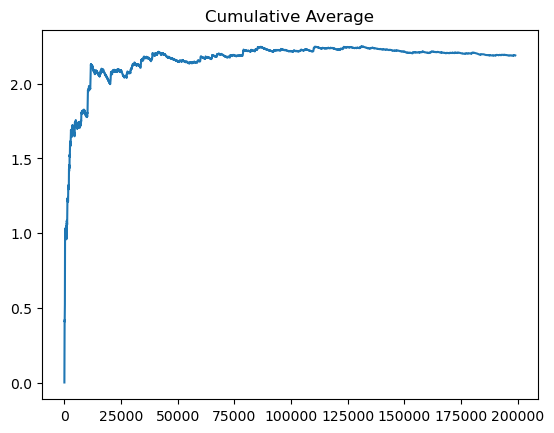

In [3]:
ZRNG = SimRNG.InitializeRNSeed()
WaitTimeAvg = []
# Parameters to specify
# Units are in minutes
MeanTBA = 1.0  # mean time-between-arrivals
MeanST = 0.8  # mean service time
Phases = 3  # nu mber of Erlang distribution phases
m = 200000  # number of customers to simulate
d = 1000 # Number of simulation experiment replications
NumReps = 1
Cum_Avg = []
for Rep in range(NumReps):
    Y = 0
    SumY = 0
    
    # # Warm-up period -- these waiting times
    # # are not saved or recorded
    for i in range(0, d):
        A = SimRNG.Expon(MeanTBA, 1)
        X = SimRNG.Erlang(Phases, MeanST, 2)
        Y = max(0, Y + X - A)

    # End of warm-up period -- these waiting times
    # are kept and used for estimation
    for j in range(d, m):
        A = SimRNG.Expon(MeanTBA, 1)
        X = SimRNG.Erlang(Phases, MeanST, 2)
        Y = max(0, Y + X - A)
        SumY = SumY + Y
        Cum_Avg.append(SumY / j)
    
    plt.plot(Cum_Avg)
    plt.title("Cumulative Average") 
    plt.show()
#     WaitTimeAvg.append(SumY/(float(m-d)))
# WaitTimeAvg = pandas.DataFrame({"WaitTimeAvg": WaitTimeAvg})
# print("Means")
# print(WaitTimeAvg.mean())


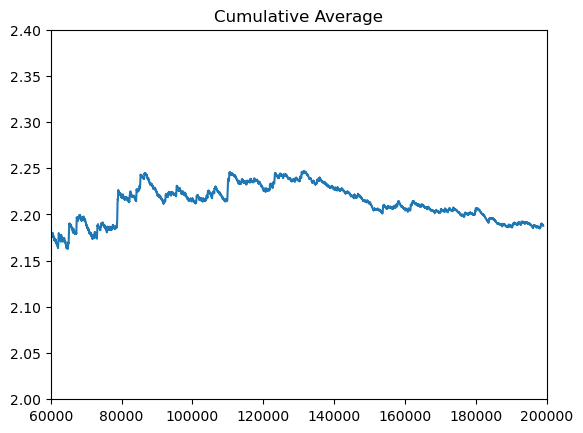

In [4]:
plt.plot(Cum_Avg)
plt.title("Cumulative Average")
plt.xlim([60000, 200000])
plt.ylim([2, 2.4])
plt.show()

- it appears that somewhere around 90,000 is where the average waiting times seem to var around the central value 2-2.1, therefore we can take d=90,000 and m=200,000

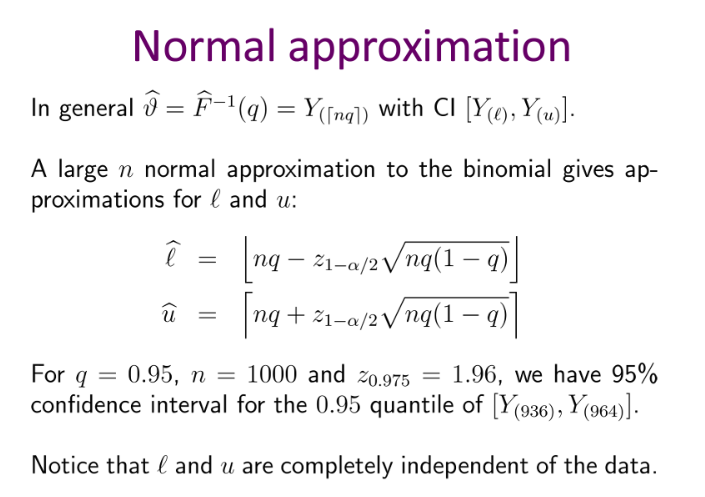

In [22]:
d = 90000 
m = 200000 
batch_size = 4000

n = (m-d) // batch_size
print(n)
q = 0.85
z = 1.96

lower_q = n*q - z * np.sqrt(n*q*(1-q))
upper_q = n*q + z * np.sqrt(n*q*(1-q))
print(np.floor(lower_q)-1, np.ceil(upper_q)-1)

27
18.0 26.0


In [24]:
ZRNG = SimRNG.InitializeRNSeed()
WaitTimeAvg = []
# Parameters to specify
# Units are in minutes
MeanTBA = 1.0  # mean time-between-arrivals
MeanST = 0.8  # mean service time
Phases = 3  # number of Erlang distribution phases

d = 90000  # number of customers in warm-up period
m = 200000  # number of customers to simulate

# Number of simulation experiment replications
NumReps = 1

# Batch size
batch_size = 4000
n = (m-d)//batch_size
batch_Sum_Y = []
WaitTimeAvg = []

np.random.seed(1)

for Rep in range(NumReps):
    # Warm-up period -- these waiting times are not saved or recorded
    for i in range(0, d):
        A = SimRNG.Expon(MeanTBA, 1)
        X = SimRNG.Erlang(Phases, MeanST, 2)
        Y = max(0, Y + X - A)

    for i in range(n):
        Y = 0
        SumY = 0
        
        for j in range(i*batch_size+d, (i+1)*batch_size+d):
            A = SimRNG.Expon(MeanTBA, 1)
            X = SimRNG.Erlang(Phases, MeanST, 2)
            Y = max(0, Y + X - A)
            SumY = SumY + Y
            
        #batch_Sum_Y.append(SumY)
        WaitTimeAvg.append(SumY/(float(batch_size)))

q = 0.85
z = 1.96

quantile_index = int(np.ceil(len(WaitTimeAvg)*q)-1)
lower_q = int(np.floor(n*q - z * np.sqrt(n*q*(1-q)))-1)
upper_q = int(np.ceil(n*q + z * np.sqrt(n*q*(1-q)))-1)

sorted_que = np.sort(WaitTimeAvg)
CI_95 = sorted_que[quantile_index]
lower_CI_95 = sorted_que[lower_q]
upper_CI_95 = sorted_que[upper_q]

print("WaitTimeAvg 0.85 quantile:", CI_95)
print("Lower CI 95:", lower_CI_95)
print("Upper CI 95:", upper_CI_95)


WaitTimeAvg 0.85 quantile: 2.2888370796482986
Lower CI 95: 2.1922350091892504
Upper CI 95: 2.861421372295472


## **P1 Results:**  

- The results for the 0.85th quantile of the WaitTimeAvg for the steady state waiting times was approx 2.28 [(-) 2.219, (+) 2.86]

# Problem 2

## **P2 Logic:**  

- I modified MG1 to become M/G/inf, where I created a new classe for the Order and used CT stat for the inventory so I can keep track of the process more efficently. I then created several functions to keep track of different components such as scheduling the Orders, Demands, and Order Arrivals while calcualting the holding and backlog cost and the total cost which is dependent of the inventory size and cost per item. The simulation works as follows, for a given (s,S) policy I initally schedual 120 (order per month) and the Demands to which the time between each demand are IID and exponetial random variables with a mean of 0.1 per month. The demands are scheduled according to the probability distribuition given for D, now this process of scheduling and order and demand are repeated 120 times where we can get the item cost of the order and the total cost (which includes holding and backlog costs) while accounting for the Order_Arrival. When an order is called it goes through a series of functions, For example, Order() will give the size of the order and schedule an arrival or when the order will be fufilled to which the Inventory class will reclaim a position and the order class will remove it from its queue. The Demand() gives the size of the items (Z) given by the probability of D and removes that many items from the inventory. Now to account for the holding and blacklog cost, the Expected_cost() function see if the current size of the inventory is greater than zero, if it is then the holding cost is calcuated by the max(current_inventory size, 0) if the size is less than 0 then the backlog cost is calculated by 5* max(-1* current inventory size, 0). In the Expected_cost() the cost adds the values produced by either function. To calculate the expected cost over 120 months, the SimRNG.Clock has values in discrete times, so to calculate the time average I summed the average ordering cost, and the cost from the Expected_cost() which includes the average holding cost and the average backlog cost for each month.



## **Q2 a)**  

In [147]:
n_reps = 1

ZSimRNG = SimRNG.InitializeRNSeed()
Calendar = SimClasses.EventCalendar()

TheQueues = []
TheCTStats = []
TheDTStats = []
TheResources = []

Inventory_CT = SimClasses.CTStat()
Inventory_CT.Xlast = 60

I_plus_CT = SimClasses.CTStat()
I_neg_CT = SimClasses.CTStat()

I_CT_list = []
I_plus_CT_list = []
I_neg_CT_list = []


class Order_Class:
    def __init__(self):
        self.Z_items = None

    def add_order(self, z_size):
        self.Z_items = z_size

    def remove_order(self):
        self.Z_items = None
        
#############################################
# Functions


def SizeOfDemand():
    U = SimRNG.Uniform(0, 1, 10)
    if U > 1/2:
        U1 = SimRNG.Uniform(0, 1, 11)
        D = 2 if U1 > 1/3 else 1
    else:
        U2 = SimRNG.Uniform(0, 1, 12)
        D = 3 if U2 > 1/3 else 4
    return D


def SizeOfOrder(s, S, I):
    if I < s:
        Z = S - I
    else:
        Z = 0
    return Z


def Order(s, S, K, i):
    Z_Size = SizeOfOrder(s, S, I=Inventory_CT.Xlast)
    Z_cost = Order_Cost(Inventory_CT.Xlast + Z_Size, K, i)
    Orders_C.add_order(Inventory_CT.Xlast + Z_Size)
    SimFunctions.Schedule(Calendar, "Order_Arrival", SimRNG.Uniform(0.5, 1, 2))
    return Z_cost, Z_Size


def Demand():
    Z_items = SizeOfDemand()
    Inventory_CT.Record(Inventory_CT.Xlast - Z_items)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 3))


def Order_Arrival(Z_size):
    if Orders_C.Z_items is not None:
        Inventory_CT.Record(Orders_C.Z_items)
        Orders_C.remove_order()


def Order_Cost(Z, K, i):
    Z_cost = K + i*Z
    return Z_cost


def Holding_cost(cost):
    I_ps = max(Inventory_CT.Xlast, 0)
    I_plus_CT.Record(I_ps)
    cost = 1 * I_ps
    return cost, I_ps


def Backlog_cost(cost):
    I_ng = max((-1 * Inventory_CT.Xlast), 0)
    I_neg_CT.Record(I_ng)
    cost = 5 * I_ng
    return cost, I_ng


def Expected_cost(cost, I_ps, I_ns):
    I_ps = 0
    I_ng = 0
    if Inventory_CT.Xlast >= 0:
        ind_cost, I_ps = Holding_cost(cost)
        I_plus_CT.Record(I_ps)
    else:
        ind_cost, I_ng = Backlog_cost(cost)
        I_neg_CT.Record(I_ng)
    cost = cost + ind_cost
    return cost, ind_cost, I_ps, I_ng


####################################################################################################################################
# Simulation
for reps in range(0, n_reps, 1):

    # Intances
    K = 32  # setup cost
    i_cost = 3  # incremental cost per item ordered
    T = 120  # 120 months
    I_0 = 60  # inital invistory level

    cost = 0
    Z_cost = 0
    order_cost = 0
    I_ps = 0
    I_ng = 0

    s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
    S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

    Orders_C = Order_Class()

    inventory_list = []
    time_list = []
    Z_cost_list = []
    Total_cost_list = []
    inv_cum_cost_list = []
    inv_per_cost_list = []
    I_ps_list = []
    I_ng_list = []
    xlast = []

    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    for time in range(1, T):
        SimFunctions.Schedule(Calendar, "Order", time)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 1))

    SimFunctions.Schedule(Calendar, "EndSimulation", T)
    NextEvent = Calendar.Remove()
    if NextEvent.EventType == "Demand":
        Demand()

    SimClasses.Clock = NextEvent.EventTime

    while NextEvent.EventType != "EndSimulation":
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        end_time = SimClasses.Clock
        if NextEvent.EventType == "Demand":
            Demand()
        elif NextEvent.EventType == "Order":
            Z_cost, Z_size = Order(s[1], S[1], K, i_cost)
        elif NextEvent.EventType == "Order_Arrival":
            Order_Arrival(Z_size)

        Z_cost_list.append(Z_cost)
        cost, per_cost, I_ps, I_ng = Expected_cost(cost, I_ps, I_ng)
        inventory_list.append(Inventory_CT.Xlast)
        time_list.append(SimClasses.Clock)
        Total_cost_list.append(cost+Z_cost)
        inv_cum_cost_list.append(cost)
        inv_per_cost_list.append(per_cost)
        I_ps_list.append(I_ps)
        I_ng_list.append(I_ng)
        I_CT_list.append(Inventory_CT.Mean())
        I_plus_CT_list.append(I_plus_CT.Mean())
        I_neg_CT_list.append(I_neg_CT.Mean())
        xlast.append(Inventory_CT.Xlast)
        
        if NextEvent.EventType == "EndSimulation":
            SimFunctions.ClearStats(TheCTStats, TheDTStats)
            Inventory_CT.Clear()
            I_plus_CT.Clear()
            I_neg_CT.Clear()

    df = pd.DataFrame({"I(t)": inventory_list,
                    "I+(t)": I_ps_list,
                    "I-(t)": I_ng_list,
                    "Time": time_list,
                    "Total Cost": Total_cost_list,
                    "Accumalated Inventory Cost": inv_cum_cost_list,
                    "Inventory Cost": inv_per_cost_list,
                    "Z items Cost": Z_cost_list,
                    "Time Avg: I(t)": I_CT_list,
                    "Time Avg: I+(t)": I_plus_CT_list,
                    "Time Avg: I-(t)": I_neg_CT_list,
                    })

df

,I(t),I+(t),I-(t),Time,Total Cost,Accumalated Inventory Cost,Inventory Cost,Z items Cost,Time Avg: I(t),Time Avg: I+(t),Time Avg: I-(t)
0,55,55,0,0.406192,55,55,55,0,57.000000,0.000000,0.000000
1,52,52,0,0.735081,107,107,52,0,56.105162,24.608032,0.000000
2,48,48,0,0.882457,155,155,48,0,55.419574,29.182665,0.000000
3,44,44,0,0.964250,199,199,44,0,54.790207,30.778850,0.000000
4,44,44,0,1.000000,407,243,44,164,54.404458,31.251505,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1401,38,38,0,119.000000,44036,43890,38,146,30.065483,30.224321,9.343577
1402,34,34,0,119.191870,44070,43924,34,146,30.078255,30.236838,9.363950
1403,32,32,0,119.503390,44102,43956,32,146,30.088479,30.246647,9.396890
1404,38,38,0,119.720453,44140,43994,38,146,30.091944,30.249826,9.419740


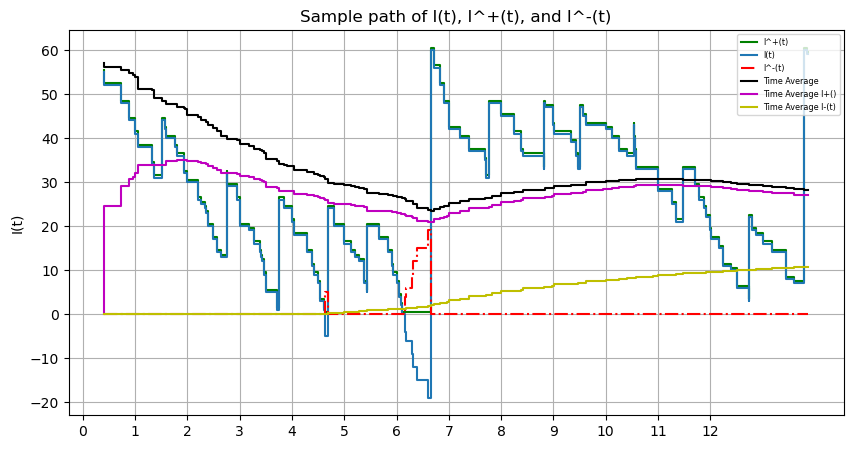

In [158]:
plt.figure(figsize=(10, 5))
plt.step(time_list[:150], np.array(df["I+(t)"][:150])+0.5, c='g', linestyle='-', label='I^+(t)')
plt.step(time_list[:150], df["I(t)"][:150], label='I(t)')
plt.step(time_list[:150], df["I-(t)"][:150], c='r', linestyle='-.', label='I^-(t)')
plt.step(time_list[:150], df["Time Avg: I(t)"][:150], c='black', label='Time Average')
plt.step(time_list[:150], df["Time Avg: I+(t)"][:150], c='m', label='Time Average I+()')
plt.step(time_list[:150], df["Time Avg: I-(t)"][:150], c='y', label='Time Average I-(t)')
plt.ylabel('I(t)')
plt.legend(loc='upper right', fontsize='xx-small')
plt.grid()
plt.xticks([i for i in range(13)])
plt.title("Sample path of I(t), I^+(t), and I^-(t)")
plt.show()


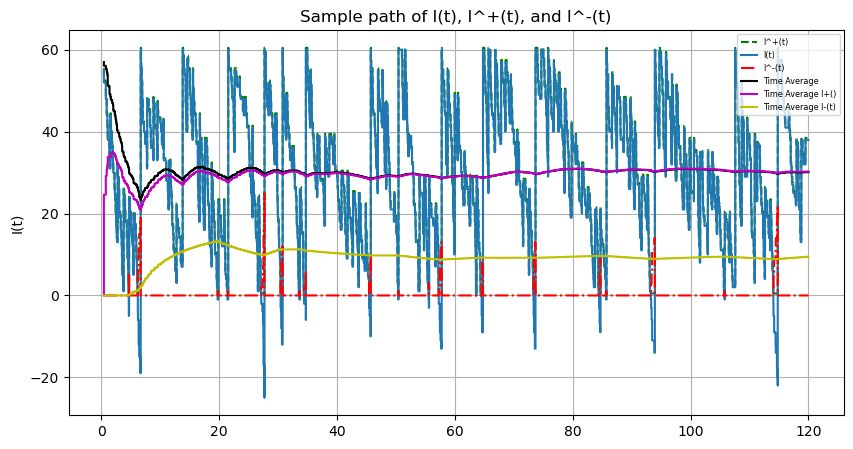

In [149]:
plt.figure(figsize=(10, 5))
plt.step(time_list[:], np.array(df["I+(t)"][:])+0.5, c='g', linestyle='--', label='I^+(t)')
plt.step(time_list[:], df["I(t)"][:], label='I(t)')
plt.step(time_list[:], df["I-(t)"][:], c='r', linestyle='-.', label='I^-(t)')
plt.step(time_list[:], df["Time Avg: I(t)"][:], c='black', label='Time Average')
plt.step(time_list[:], df["Time Avg: I+(t)"][:], c='m', label='Time Average I+()')
plt.step(time_list[:], df["Time Avg: I-(t)"][:], c='y', label='Time Average I-(t)')
plt.ylabel('I(t)')
plt.legend(loc='upper right', fontsize='xx-small')
plt.grid()
#plt.xticks([i for i in range(13)])
plt.title("Sample path of I(t), I^+(t), and I^-(t)")
plt.show()


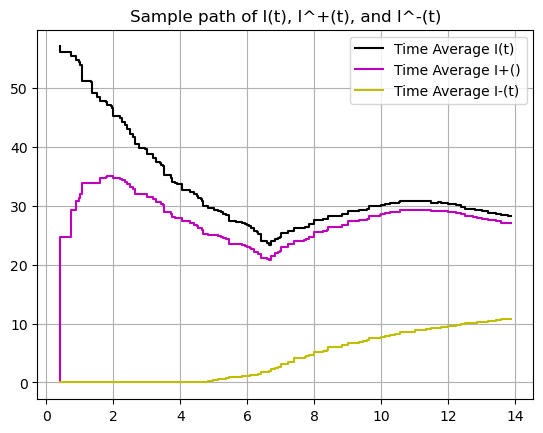

In [150]:
plt.step(time_list[:150], df["Time Avg: I(t)"][:150], c='black', label='Time Average I(t)')
plt.step(time_list[:150], df["Time Avg: I+(t)"][:150], c='m', label='Time Average I+()')
plt.step(time_list[:150], df["Time Avg: I-(t)"][:150], c='y', label='Time Average I-(t)')
plt.legend()
plt.grid()
#plt.xticks([i for i in range(13)])
plt.title("Sample path of I(t), I^+(t), and I^-(t)")
plt.show()


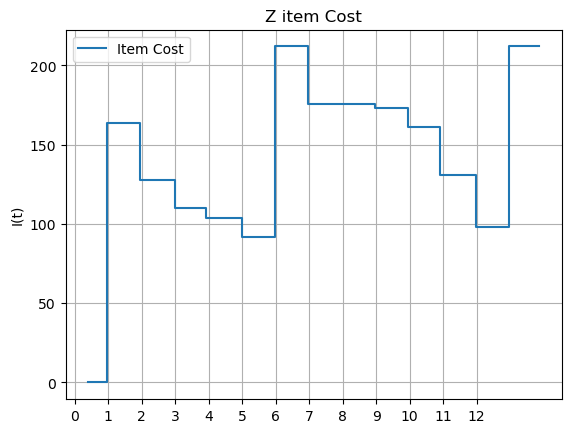

In [151]:
plt.step(time_list[:150], df["Z items Cost"][:150], label='Item Cost')
plt.ylabel('I(t)')
plt.legend()
plt.xticks([i for i in range(13)])
plt.grid()
plt.title("Z item Cost")
plt.show()


In [152]:
averages = []
for i in range(1, 121):
    j = next((idx for idx, val in enumerate(df["Time"]) if val > i), len(df["Time"]))
    avg = df["Z items Cost"][j-1:j]
    averages.append(avg)
Avg_Item_cost = np.mean(averages)
print(f"Expected Item Cost: ${Avg_Item_cost}")


Expected Item Cost: $159.525


In [154]:
df[-1:]

,I(t),I+(t),I-(t),Time,Total Cost,Accumalated Inventory Cost,Inventory Cost,Z items Cost,Time Avg: I(t),Time Avg: I+(t),Time Avg: I-(t)
1405,38,38,0,120.0,44178,44032,38,146,30.110367,30.267881,9.449047


In [155]:
time_avgs = df[["Time Avg: I+(t)", "Time Avg: I-(t)"]][-1:].values[0]
avg_holding_cost = 1*time_avgs[0]
avg_backlog_cost = 5*time_avgs[1]

Expected_Cost = avg_holding_cost + avg_backlog_cost + Avg_Item_cost
print(f"Expected Cost: ${Expected_Cost}")


Expected Cost: $237.03811514369153


## **Q2 b)**  

In [28]:
def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, "+/-", hw

In [39]:
n_reps = 500

ZSimRNG = SimRNG.InitializeRNSeed()
Calendar = SimClasses.EventCalendar()

TheQueues = []
TheCTStats = []
TheDTStats = []
TheResources = []

Inventory_CT = SimClasses.CTStat()
Inventory_CT.Xlast = 60

I_plus_CT = SimClasses.CTStat()
I_neg_CT = SimClasses.CTStat()

class Order_Class:
    def __init__(self):
        self.Z_items = None

    def add_order(self, z_size):
        self.Z_items = z_size

    def remove_order(self):
        self.Z_items = None

#############################################
# Functions


def SizeOfDemand():
    U = SimRNG.Uniform(0, 1, 10)
    if U > 1/2:
        U1 = SimRNG.Uniform(0, 1, 11)
        D = 2 if U1 > 1/3 else 1
    else:
        U2 = SimRNG.Uniform(0, 1, 12)
        D = 3 if U2 > 1/3 else 4
    return D


def SizeOfOrder(s, S, I):
    if I < s:
        Z = S - I
    else:
        Z = 0
    return Z


def Order(s, S, K, i):
    Z_Size = SizeOfOrder(s, S, I=Inventory_CT.Xlast)
    Z_cost = Order_Cost(Inventory_CT.Xlast + Z_Size, K, i)
    Orders_C.add_order(Inventory_CT.Xlast + Z_Size)
    SimFunctions.Schedule(Calendar, "Order_Arrival", SimRNG.Uniform(0.5, 1, 2))
    return Z_cost, Z_Size


def Demand():
    Z_items = SizeOfDemand()
    Inventory_CT.Record(Inventory_CT.Xlast - Z_items)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 3))


def Order_Arrival(Z_size):
    if Orders_C.Z_items is not None:
        Inventory_CT.Record(Orders_C.Z_items)
        Orders_C.remove_order()


def Order_Cost(Z, K, i):
    Z_cost = K + i*Z
    return Z_cost


def Holding_cost(cost):
    I_ps = max(Inventory_CT.Xlast, 0)
    I_plus_CT.Record(I_ps)
    cost = 1 * I_ps
    return cost, I_ps


def Backlog_cost(cost):
    I_ng = max((-1 * Inventory_CT.Xlast), 0)
    I_neg_CT.Record(I_ng)
    cost = 5 * I_ng
    return cost, I_ng


def Expected_cost(cost, I_ps, I_ns):
    I_ps = 0
    I_ng = 0
    if Inventory_CT.Xlast >= 0:
        ind_cost, I_ps = Holding_cost(cost)
        I_plus_CT.Record(I_ps)
    else:
        ind_cost, I_ng = Backlog_cost(cost)
        I_neg_CT.Record(I_ng)
    cost = cost + ind_cost
    return cost, ind_cost, I_ps, I_ng

Item_cost_means = []
I_plus_CT_list_means = []
I_neg_CT_list_means = []
Expected_Cost_list = []
####################################################################################################################################
# Simulation
for reps in range(0, n_reps, 1):

    #############################################
    # Intances
    K = 32  # setup cost
    i_cost = 3  # incremental cost per item ordered
    T = 120  # 120 months
    I_0 = 60  # inital invistory level

    cost = 0
    Z_cost = 0
    order_cost = 0
    I_ps = 0
    I_ng = 0
    time_avgs = 0
    avg_holding_cost = 0
    avg_backlog_cost = 0
    Avg_Item_cost = 0
    Expected_Cost = 0

    s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
    S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

    Orders_C = Order_Class()

    inventory_list = []
    time_list = []
    Z_cost_list = []
    Total_cost_list = []
    inv_cum_cost_list = []
    inv_per_cost_list = []
    I_ps_list = []
    I_ng_list = []
    xlast = []
    I_CT_list = []
    I_plus_CT_list = []
    I_neg_CT_list = []
    
    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    for time in range(1, T):
        SimFunctions.Schedule(Calendar, "Order", time)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 1))

    SimFunctions.Schedule(Calendar, "EndSimulation", T)
    NextEvent = Calendar.Remove()
    if NextEvent.EventType == "Demand":
        Demand()

    SimClasses.Clock = NextEvent.EventTime

    while NextEvent.EventType != "EndSimulation":
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        end_time = SimClasses.Clock
        if NextEvent.EventType == "Demand":
            Demand()
        elif NextEvent.EventType == "Order":
            Z_cost, Z_size = Order(s[0], S[0], K, i_cost)
        elif NextEvent.EventType == "Order_Arrival":
            Order_Arrival(Z_size)
            
        Z_cost_list.append(Z_cost)
        cost, per_cost, I_ps, I_ng = Expected_cost(cost, I_ps, I_ng)
        inventory_list.append(Inventory_CT.Xlast)
        time_list.append(SimClasses.Clock)
        Total_cost_list.append(cost+Z_cost)
        inv_cum_cost_list.append(cost)
        inv_per_cost_list.append(per_cost)
        I_ps_list.append(I_ps)
        I_ng_list.append(I_ng)
        I_CT_list.append(Inventory_CT.Mean())
        I_plus_CT_list.append(I_plus_CT.Mean())
        I_neg_CT_list.append(I_neg_CT.Mean())
        xlast.append(Inventory_CT.Xlast)
        
        if NextEvent.EventType == "EndSimulation":
            SimFunctions.ClearStats(TheCTStats, TheDTStats)
            Inventory_CT.Clear()
            I_plus_CT.Clear()
            I_neg_CT.Clear()
        
    df = pd.DataFrame({"I(t)": inventory_list,
                    "I+(t)": I_ps_list,
                    "I-(t)": I_ng_list,
                    "Time": time_list,
                    "Total Cost": Total_cost_list,
                    "Accumalated Inventory Cost": inv_cum_cost_list,
                    "Inventory Cost": inv_per_cost_list,
                    "Z items Cost": Z_cost_list,
                    "Time Avg: I(t)": I_CT_list,
                    "Time Avg: I+(t)": I_plus_CT_list,
                    "Time Avg: I-(t)": I_neg_CT_list,
                    })
    averages = []
    for i in range(1, 121):
        j = next((idx for idx, val in enumerate(df["Time"]) if val > i), len(df["Time"]))
        avg = df["Z items Cost"][j-1:j]
        averages.append(avg)
        
    Avg_Item_cost = np.mean(averages)
    time_avgs = df[["Time Avg: I+(t)", "Time Avg: I-(t)"]][-1:].values[0]
    
    Item_cost_means.append(Avg_Item_cost)
    I_plus_CT_list_means.append(time_avgs[0])
    I_neg_CT_list_means.append(time_avgs[1])

    avg_holding_cost = 1*time_avgs[0]
    avg_backlog_cost = 5*time_avgs[1]

    Expected_Cost = avg_holding_cost + avg_backlog_cost + Avg_Item_cost
    Expected_Cost_list.append(Expected_Cost)

print("95% Confidence Interval of Expected Cost for s=20, S=40 | ${}".format(CI_95(Expected_Cost_list)))
print(f"Variance of Expected Cost: {np.var(Expected_Cost_list, ddof=1)}")

95% Confidence Interval of Expected Cost for s=20, S=40 | $(128.76564573396087, '+/-', 0.2827783032930371)
Variance of Expected Cost: 10.407586528176918


## **Q2 c)**  

### **Q2 c) Logic:**

- To use the subset selection method, I first computed the t value using scipy where we know the value of alpha, K and ni/nh being the number of reps. So after intiallizing these values, I used the same code in 2b but just added another for loop to compute the expected costs for different policies. From here I implemented the weights for each sample variance compared to the other policies and then check that if the sample mean of the currently policy is less than or equal to the sample means + its respective weight of all the other policies in s,S and extracted any policy that satisfied this constraint.

In [160]:
K = 9
alpha = 0.05
x = (1-alpha)**(1/(K-1))
n_reps = 100
df = n-1
ti = t.ppf(x, df)
th = ti

In [72]:
class Order_Class:
    def __init__(self):
        self.Z_items = None

    def add_order(self, z_size):
        self.Z_items = z_size

    def remove_order(self):
        self.Z_items = None

#############################################
# Functions


def SizeOfDemand():
    U = SimRNG.Uniform(0, 1, 10)
    if U > 1/2:
        U1 = SimRNG.Uniform(0, 1, 11)
        D = 2 if U1 > 1/3 else 1
    else:
        U2 = SimRNG.Uniform(0, 1, 12)
        D = 3 if U2 > 1/3 else 4
    return D


def SizeOfOrder(s, S, I):
    if I < s:
        Z = S - I
    else:
        Z = 0
    return Z


def Order(s, S, K, i):
    Z_Size = SizeOfOrder(s, S, I=Inventory_CT.Xlast)
    Z_cost = Order_Cost(Inventory_CT.Xlast + Z_Size, K, i)
    Orders_C.add_order(Inventory_CT.Xlast + Z_Size)
    SimFunctions.Schedule(Calendar, "Order_Arrival", SimRNG.Uniform(0.5, 1, 2))
    return Z_cost, Z_Size


def Demand():
    Z_items = SizeOfDemand()
    Inventory_CT.Record(Inventory_CT.Xlast - Z_items)
    SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 3))


def Order_Arrival(Z_size):
    if Orders_C.Z_items is not None:
        Inventory_CT.Record(Orders_C.Z_items)
        Orders_C.remove_order()


def Order_Cost(Z, K, i):
    Z_cost = K + i*Z
    return Z_cost


def Holding_cost(cost):
    I_ps = max(Inventory_CT.Xlast, 0)
    I_plus_CT.Record(I_ps)
    cost = 1 * I_ps
    return cost, I_ps


def Backlog_cost(cost):
    I_ng = max((-1 * Inventory_CT.Xlast), 0)
    I_neg_CT.Record(I_ng)
    cost = 5 * I_ng
    return cost, I_ng


def Expected_cost(cost, I_ps, I_ns):
    I_ps = 0
    I_ng = 0
    if Inventory_CT.Xlast >= 0:
        ind_cost, I_ps = Holding_cost(cost)
        I_plus_CT.Record(I_ps)
    else:
        ind_cost, I_ng = Backlog_cost(cost)
        I_neg_CT.Record(I_ng)
    cost = cost + ind_cost
    return cost, ind_cost, I_ps, I_ng

####################################################################################################################################

sample_means_poly = []
sample_var_poly = []
s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

for i_s in range(len(S)):
    
    ZSimRNG = SimRNG.InitializeRNSeed()
    Calendar = SimClasses.EventCalendar()

    TheQueues = []
    TheCTStats = []
    TheDTStats = []
    TheResources = []

    Inventory_CT = SimClasses.CTStat()
    Inventory_CT.Xlast = 60

    I_plus_CT = SimClasses.CTStat()
    I_neg_CT = SimClasses.CTStat()

    Item_cost_means = []
    I_plus_CT_list_means = []
    I_neg_CT_list_means = []
    Expected_Cost_list = []
    
    # Simulation
    for reps in range(0, n_reps, 1):

        #############################################
        # Intances
        K = 32  # setup cost
        i_cost = 3  # incremental cost per item ordered
        T = 120  # 120 months
        I_0 = 60  # inital invistory level

        cost = 0
        Z_cost = 0
        order_cost = 0
        I_ps = 0
        I_ng = 0
        time_avgs = 0
        avg_holding_cost = 0
        avg_backlog_cost = 0
        Avg_Item_cost = 0
        Expected_Cost = 0

        s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
        S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

        ############################################
        Orders_C = Order_Class()

        inventory_list = []
        time_list = []
        Z_cost_list = []
        Total_cost_list = []
        inv_cum_cost_list = []
        inv_per_cost_list = []
        I_ps_list = []
        I_ng_list = []
        xlast = []
        I_CT_list = []
        I_plus_CT_list = []
        I_neg_CT_list = []

        SimFunctions.SimFunctionsInit(
            Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        for time in range(1, T):
            SimFunctions.Schedule(Calendar, "Order", time)
        SimFunctions.Schedule(Calendar, "Demand", SimRNG.Expon(0.1, 1))

        SimFunctions.Schedule(Calendar, "EndSimulation", T)
        NextEvent = Calendar.Remove()
        if NextEvent.EventType == "Demand":
            Demand()

        SimClasses.Clock = NextEvent.EventTime

        while NextEvent.EventType != "EndSimulation":
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            end_time = SimClasses.Clock
            if NextEvent.EventType == "Demand":
                Demand()
            elif NextEvent.EventType == "Order":
                Z_cost, Z_size = Order(s[i_s], S[i_s], K, i_cost)
            elif NextEvent.EventType == "Order_Arrival":
                Order_Arrival(Z_size)

            Z_cost_list.append(Z_cost)
            cost, per_cost, I_ps, I_ng = Expected_cost(cost, I_ps, I_ng)
            inventory_list.append(Inventory_CT.Xlast)
            time_list.append(SimClasses.Clock)
            Total_cost_list.append(cost+Z_cost)
            inv_cum_cost_list.append(cost)
            inv_per_cost_list.append(per_cost)
            I_ps_list.append(I_ps)
            I_ng_list.append(I_ng)
            I_CT_list.append(Inventory_CT.Mean())
            I_plus_CT_list.append(I_plus_CT.Mean())
            I_neg_CT_list.append(I_neg_CT.Mean())
            xlast.append(Inventory_CT.Xlast)

            if NextEvent.EventType == "EndSimulation":
                SimFunctions.ClearStats(TheCTStats, TheDTStats)
                Inventory_CT.Clear()
                I_plus_CT.Clear()
                I_neg_CT.Clear()

        df = pd.DataFrame({"I(t)": inventory_list,
                        "I+(t)": I_ps_list,
                        "I-(t)": I_ng_list,
                        "Time": time_list,
                        "Total Cost": Total_cost_list,
                        "Accumalated Inventory Cost": inv_cum_cost_list,
                        "Inventory Cost": inv_per_cost_list,
                        "Z items Cost": Z_cost_list,
                        "Time Avg: I(t)": I_CT_list,
                        "Time Avg: I+(t)": I_plus_CT_list,
                        "Time Avg: I-(t)": I_neg_CT_list,
                        })
        averages = []
        for i in range(1, 121):
            j = next((idx for idx, val in enumerate(
                df["Time"]) if val > i), len(df["Time"]))
            avg = df["Z items Cost"][j-1:j]
            averages.append(avg)

        Avg_Item_cost = np.mean(averages)
        time_avgs = df[["Time Avg: I+(t)", "Time Avg: I-(t)"]][-1:].values[0]

        Item_cost_means.append(Avg_Item_cost)
        I_plus_CT_list_means.append(time_avgs[0])
        I_neg_CT_list_means.append(time_avgs[1])

        avg_holding_cost = 1*time_avgs[0]
        avg_backlog_cost = 5*time_avgs[1]

        Expected_Cost = avg_holding_cost + avg_backlog_cost + Avg_Item_cost
        Expected_Cost_list.append(Expected_Cost)
    sample_var_poly.append(np.var(Expected_Cost_list, ddof=1))
    sample_means_poly.append(np.mean(Expected_Cost_list))


In [156]:
sample_means_poly

[129.08103080611852,
 160.41794441496242,
 190.551405956724,
 220.96303467106486,
 188.98362073237837,
 219.3561009762003,
 250.46626172555173,
 248.93434115593382,
 280.55627305751165]

In [135]:
s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

w_ih = 0
w_ih_list = []

I = set()

for i in range(len(s)):
    for j in range(len(S)):
        if i != j:
            w_ih = np.sqrt((ti**2) * (sample_var_poly[i] / n_reps) + (th**2) * (sample_var_poly[j] / n_reps))
            if sample_means_poly[i] > sample_means_poly[j] + w_ih:
                break
            else:
                I.add((s[i], S[i]))

In [136]:
I

{(20, 40)}

## **P2 Results:**  

- After computing the expected cost for policy (20, 40) in part b, the 95% Confidence Interval of Expected Cost was $128.76564573396087 +/- 0.28277 with a variance $10.4. After creating a subset of 'good policies' where the condition of a sample mean having to be less than all the other policies + their weight the only policy in the list was (20,40). Additionally, when looking at the expected cost of all the policies, (20,40) has the smallest amount. Thus we can conclude that this policy will be the most optimal for the inventory problem for this company.


# Problem 3

## **P3 Logic:**  
3a)
- To estimate the gradient of E[Y(x)] of the SAN simulation I first used the Finite difference method which estimates the difference between the mean time to complete a prokect for scenarios (x+delta_x) and x. This was done by doing 5 loops, 1 for each value of xj where I changed the x[j] = x[j] + delta_x where it will then be passed through repetitions. There are two different Y's that calculate the max path of A(x) and A(x + delta_x) separately using Common Random Numbers. I then calculate the gradient for the respective x[j] by subracting the Y_(x + delta_x) - Y_x / delta_x to get the finite difference to which I take the sample average (though the CI95) and the sample variance. 

3b)
- To estimate the gradient of E[Y(x)] of the SAN simulation using Infinitesimal Perturbation Analysis, I made cases for each value of x. In the case of x[j] if j = 1, then the IPA is calcualted by the A[j]/x[j] * *I*. *I* is an indicator function such that if A[j] is not on the maximum path then *I* is equal to 0. After 5 loops, I took the sample average (though the CI95) and the sample variance for each IPA of xj. 

3c)
- For the stocasitc approximation search, I first notabley used the finite difference method from 3a to calculate the gradient which will be used to find the optimal activity means through the formula x = x - alpha*gradient. As this is a search, I initalized contraints being a cost function (cj * (tj - xj)) where the cost must be less than or equal to the budget b and the value of xj > lj where lk is the smallest achievable mean activity time for activity j. If any of these constraints are broken the loop will stop, and the result should be the optimal activity mean time where the budjet is close to being fully utalized. To note, the alpha was updated each repetition by dividing the inital value by the number of reps to which each step gets larger. 


## **3a)** FD

In [31]:
def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, "+/-", hw

np.random.seed(1)

N = 1000
delta_x = 0.1
x = [0.5, 1, 0.7, 1, 1]
#x_dx = [0.5, 1, 0.7, 1, 1]
x1s = []
x2s = []
x3s = []
x4s = []
x5s = []

print("Estimate Gradient of E[Y(x)] using Finite Difference (FDA)\n")
asd = 0
for j in range(0, 5, 1):
    Y_list = []
    Y_dx_list = []
    E_FD_list = []
    Var_DF_list = []

    x_dx = [0.5, 1, 0.7, 1, 1]
    x_dx[j] += delta_x
    SumFD = 0

    for rep in range(0, N, 1):
        U = np.random.random(5)
        X = []
        X_dx = []
        for i in range(0, 5, 1):
            X.append(-np.log(1-U[i])*x[i])
            X_dx.append(-np.log(1-U[i])*x_dx[i])

        P1 = X[0] + X[3]
        P2 = X[0] + X[2] + X[4]
        P3 = X[1] + X[4]

        x1s.append(X[0])
        x2s.append(X[1])
        x3s.append(X[2])
        x4s.append(X[3])
        x5s.append(X[4])

        
        P1_dx = X_dx[0] + X_dx[3]
        P2_dx = X_dx[0] + X_dx[2] + X_dx[4]
        P3_dx = X_dx[1] + X_dx[4]

        Y = max(P1, P2, P3)
        Y_list.append(Y)
        Y_dx = max(P1_dx, P2_dx, P3_dx)

        Y_dx_list.append(Y_dx)
        FD = (Y_dx - Y) / delta_x
        # SumFD = SumFD + FD #/ (rep+1)
        E_FD_list.append(FD)

        Var_DF = (Y_dx - Y)
        Var_DF_list.append(Var_DF)

    std = np.std(E_FD_list, ddof=1)
    ci = std/np.sqrt(len(E_FD_list))   
    print("for x_{} || 95% Confidence Intervals || Mean {} || Variance = {} +/- {} \n".format(j + 1, CI_95(E_FD_list), np.var(E_FD_list, ddof=1), 1.96*ci))

Estimate Gradient of E[Y(x)] using Finite Difference (FDA)

for x_1 || 95% Confidence Intervals || Mean (0.7525909366723706, '+/-', 0.06389502521062035) || Variance = 1.0627275735802293 +/- 0.06389502521062033 

for x_2 || 95% Confidence Intervals || Mean (0.619661382067618, '+/-', 0.06545775737641576) || Variance = 1.1153472513405127 +/- 0.06545775737641578 

for x_3 || 95% Confidence Intervals || Mean (0.6641945881337543, '+/-', 0.06230916072878103) || Variance = 1.0106287772607943 +/- 0.062309160728781024 

for x_4 || 95% Confidence Intervals || Mean (0.498955271315346, '+/-', 0.0645199097491962) || Variance = 1.0836158772502142 +/- 0.0645199097491962 

for x_5 || 95% Confidence Intervals || Mean (0.9112412266547053, '+/-', 0.06430416807285691) || Variance = 1.0763812035459783 +/- 0.06430416807285691 



In [32]:
print(np.mean(x1s))
print(np.mean(x2s))
print(np.mean(x3s))
print(np.mean(x4s))
print(np.mean(x5s))


0.48321893588929604
1.0033140774003286
0.6924951649877424
1.0071947807307933
1.0289087594792048


## **3b)** IPA

In [33]:
def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, "+/-", hw

np.random.seed(1)

N = 1000

# Choose the value of x (corresponding to x1 in the notation used in the slides)
x = [0.5, 1, 0.7, 1, 1]

print("Estimate Gradient of E[Y(x)] using Infinitesimal Perturbation Analysis (IPA)\n")


for j in range(0, 5, 1):
    IPA = 0
    Y_list = []
    Y_dx_list = []
    E_ID_list = []
    Var_DF_list = []
    for rep in range(0, N, 1):
        U = np.random.random(5)
        X = []
        X_dx = []
        
        for i in range(0, 5, 1):
            X.append(-np.log(1-U[i])*x[i])
        
        P1 = X[0] + X[3]
        P2 = X[0] + X[2] + X[4]
        P3 = X[1] + X[4]
        Y = max(P1, P2, P3)
        Y_list.append(Y)

        if j == 0:
            I = (Y == P1) or (Y == P2)
            IPA = (X[j] / x[j]) * I
            
        elif j == 1:
            I = (Y == P3)
            IPA = (X[j] / x[j]) * I
        
        elif j == 2:
            I = (Y == P2)
            IPA = (X[j] / x[j]) * I
        
        elif j == 3:
            I = (Y == P1)
            IPA = (X[j] / x[j]) * I
            
        elif j == 4:
            I = (Y == P2) or (Y == P3)
            IPA = (X[j] / x[j]) * I
                
        E_ID_list.append(IPA)   

    std = np.std(E_ID_list, ddof=1)

    ci = std/np.sqrt(len(E_ID_list))

    print("for x_{} || 95% Confidence Intervals || Mean {} || Variance = {} +/- {} \n".format(j + 1, CI_95(E_ID_list), np.var(E_ID_list, ddof=1), 1.96*ci))


Estimate Gradient of E[Y(x)] using Infinitesimal Perturbation Analysis (IPA)

for x_1 || 95% Confidence Intervals || Mean (0.7388930164995419, '+/-', 0.0637982411653) || Variance = 1.0595105101483184 +/- 0.0637982411653 

for x_2 || 95% Confidence Intervals || Mean (0.5925300156130359, '+/-', 0.06562256051878143) || Variance = 1.1209705458770125 +/- 0.06562256051878143 

for x_3 || 95% Confidence Intervals || Mean (0.6458758310880294, '+/-', 0.062306277696048525) || Variance = 1.0105352562310268 +/- 0.062306277696048525 

for x_4 || 95% Confidence Intervals || Mean (0.4812613691652413, '+/-', 0.06454817111657675) || Variance = 1.0845653879880448 +/- 0.06454817111657674 

for x_5 || 95% Confidence Intervals || Mean (0.905737862428826, '+/-', 0.06446000039677492) || Variance = 1.0816044489671555 +/- 0.06446000039677492 



## **3c)** Stochastic Approximation

iter 0 | cost: 0 | E[Y(x)] = 3.427596935658125
iter 10 | cost: 0.3870002192080485 | E[Y(x)] = 3.1461522869928182
iter 20 | cost: 0.5206644904566147 | E[Y(x)] = 3.048144744775104
iter 30 | cost: 0.6104155293900524 | E[Y(x)] = 2.982230080167649
iter 40 | cost: 0.6796698590946302 | E[Y(x)] = 2.931363081030742
iter 50 | cost: 0.7367583182195149 | E[Y(x)] = 2.8894044339432075
iter 60 | cost: 0.7856863314778089 | E[Y(x)] = 2.853430995780675
iter 70 | cost: 0.8287230389471251 | E[Y(x)] = 2.82181204269051
iter 80 | cost: 0.8672775304581785 | E[Y(x)] = 2.793568543683136
iter 90 | cost: 0.9022927285768804 | E[Y(x)] = 2.7679099419715834
iter 100 | cost: 0.9344323449991401 | E[Y(x)] = 2.744387665725481
iter 110 | cost: 0.9641802357067198 | E[Y(x)] = 2.7226422223847018
iter 120 | cost: 0.9919068652554789 | E[Y(x)] = 2.702366447877651
END: iter 123 | cost: 0.9998758730181713 | E[Y(x)] = 2.696537774975888
Optimal activity mean times: [0.74679413 0.84671422 0.76644387 0.89253147 0.74501747]


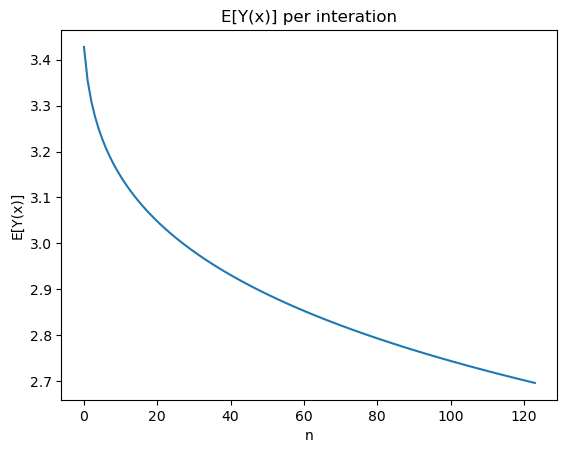

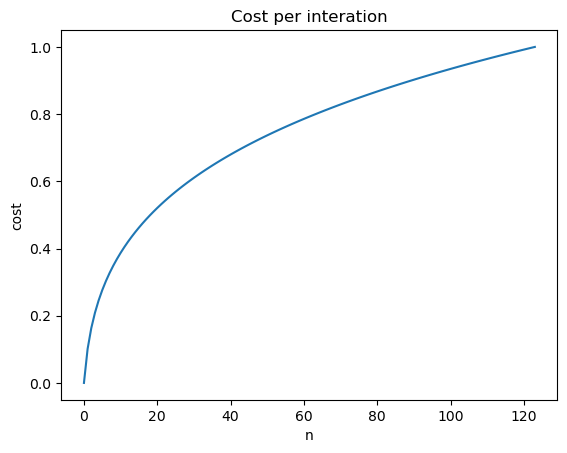

In [34]:
def FD(x, N):
    np.random.seed(1)
    delta_x = 0.1
    x_dx = [1, 1, 1, 1, 1]

    gradient_list = []
    YY_list = []

    for j in range(0, 5, 1):
        Y_list = []
        Y_dx_list = []
        E_FD_list = []

        xx_dx = x.copy()
        xx_dx[j] = x_dx[j] + delta_x
        SumFD = 0

        for rep in range(0, N, 1):
            U = np.random.random(5)
            X = []
            X_dx = []
            for i in range(0, 5, 1):
                X.append(-np.log(1-U[i])*x[i])
                X_dx.append(-np.log(1-U[i])*xx_dx[i])

            P1 = X[0] + X[3]
            P2 = X[0] + X[2] + X[4]
            P3 = X[1] + X[4]

            P1_dx = X_dx[0] + X_dx[3]
            P2_dx = X_dx[0] + X_dx[2] + X_dx[4]
            P3_dx = X_dx[1] + X_dx[4]

            Y = max(P1, P2, P3)
            Y_list.append(Y)
            Y_dx = max(P1_dx, P2_dx, P3_dx)

            Y_dx_list.append(Y_dx)
            FD = (Y_dx - Y) / delta_x
            # SumFD = SumFD + FD #/ (rep+1)
            E_FD_list.append(FD)
        
            YY_list.append(np.mean(Y_list))

        gradient_list.append(np.mean(E_FD_list))
            
    return gradient_list, YY_list

np.random.seed(1)

N = 150

t = [1, 1, 1, 1, 1]
c = [1, 1, 1, 1, 1]
l = [0.5, 0.5, 0.5, 0.5, 0.5]
b = 1

inter = []
d_x = 0.1
alpha_0 = 0.03

# Starting values
x = [1, 1, 1, 1, 1]

x_new_list = []
Y_list = []
cost_list = []
fd_list = []
EY_list = []
cost_l = []
c1 = False

for n in range(0, N, 1):

    cost_l = []
    # Calculate the gradient of E[Y(x)] using finite difference
    gradient, Y = FD(x, N)
    
    for j in range(5):
        cost_l.append(c[j] * (t[j] - x[j]))
        # check constraint
        if x[j] < l[j]:
            c1 = True
    cost = np.sum(cost_l)

    if cost > b:
        break

    if c1 == True:
        break

    # Update x_i+1
    alpha = alpha_0 / (n+1)
    x = x - alpha * np.array(gradient)

    inter.append(n)
    EY_list.append(np.mean(Y))
    fd_list.append(gradient)
    cost_list.append(cost)

    if n % 10 == 0:
        print("iter {} | cost: {} | E[Y(x)] = {}".format(n, cost, EY_list[n]))

print("END: iter {} | cost: {} | E[Y(x)] = {}".format(max(inter), cost_list[max(inter)], EY_list[max(inter)]))
print("Optimal activity mean times: {}".format(x))
plt.figure()
plt.plot(inter, EY_list)
plt.ylabel("E[Y(x)]")
plt.xlabel("n")
plt.title("E[Y(x)] per interation")
plt.show()

plt.figure()
plt.plot(inter, cost_list)
plt.ylabel("cost")
plt.xlabel("n")
plt.title("Cost per interation")
plt.show()


## **P3 Results:**  

- 3a) & 3b) produced very similar estimates where the FD had around a 0.01-0.02 higher difference in the graident values. When looking at the variance, the theorical results are apparent as the variance for both FD and IPA methods are high due to their sensitivity to model input/parameters.

- 3c) From both the plots of the expected value of Y(x) and cost for each interation to the optimal activity means times, we can see the progression of the stocastic approximation search. We can see a tradeoff in the plots where the E[Y(x)] plot is decending and the cost is ascending which implies that the search is correctly optimizing the activity mean times.

# Problem 4

## **P4 Logic:**  

- 4a) I took the inverse CDF and uniformly sampled values u to which I can create a distribution where I can same to get a similar distribution to the PDF. By sampling from the inverse CDF distribution I can get the demand D for the objection function which mimizes the expected total cost.

- 4b)/4c)

## **4a)**

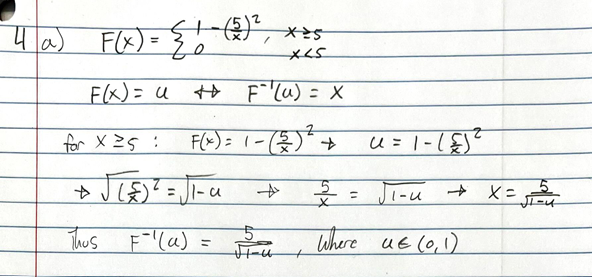

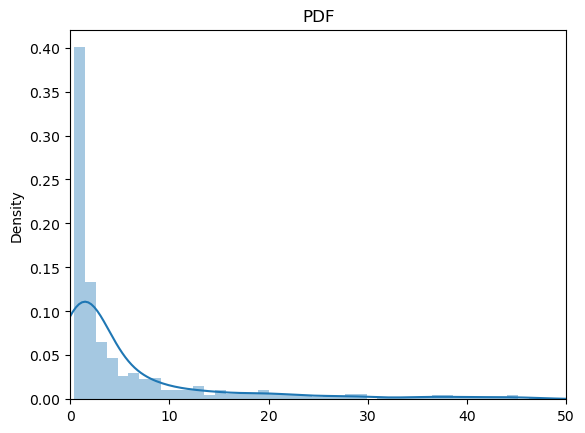

In [35]:
#pdf
n = 1000
f_x_list = []
np.random.seed(1)

for i in range(n):
    x = np.random.uniform(low=5)
    f_x = 50/(x**3)
    f_x_list.append(f_x)

sns.distplot(f_x_list)
plt.title("PDF")
plt.xlim([0, 50])
plt.show()

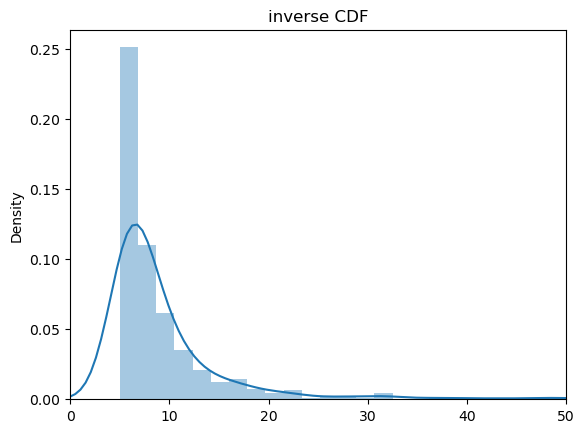

In [36]:
#inv_cdf
n = 1000
D_list = []
np.random.seed(1)

for i in range(n):
    u = np.random.random()
    D = 5/(np.sqrt(1-u))
    D_list.append(D)
    
sns.distplot(D_list)
plt.title("inverse CDF")
plt.xlim([0,50])
plt.show()

- Can see that the inverse CDF produces similar shape to the pdf of the function. By sampling the inverse CDF we can generate samples for our linear program, this method is also known as the inverse transform methods/sampling

## **4b)**

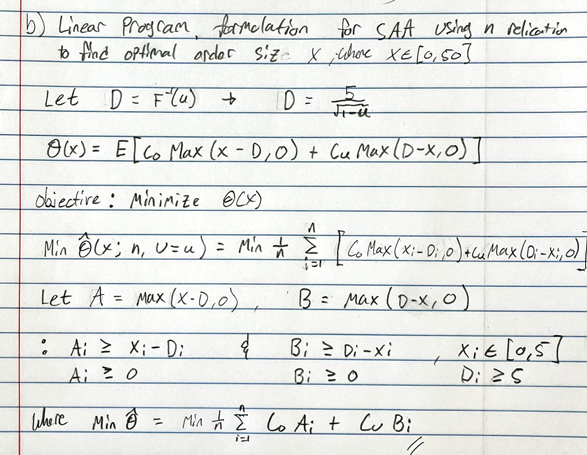

## **4c)**

In [37]:
import gurobipy as gp
from gurobipy import GRB

n = 500
c_0 = 1
c_u = 2
np.random.seed(1)
m = gp.Model()

x = m.addVar(lb=0, ub=50, name="x")
A_i = m.addVars(n, lb=0, name="A")
B_i = m.addVars(n, lb=0, name="B")

for i in range(n):
    D_i = 5 / (np.sqrt(1 - np.random.random()))
    m.addConstr(A_i[i] >= x - D_i)
    m.addConstr(A_i[i] >= 0)
    m.addConstr(B_i[i] >= D_i - x)
    m.addConstr(B_i[i] >= 0)

total_theta = sum(c_0 * A_i[i] + c_u * B_i[i] for i in range(n))
m.setObjective(total_theta / n, GRB.MINIMIZE)

m.optimize()

print("----------------------------------------------------------------")
if m.status == GRB.Status.OPTIMAL:
    print("Optimal x:", x.x)
else:
    print("Optimization did not converge")

print(f"Minimum Objective: {m.objVal}")


Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2000 rows, 1001 columns and 3000 nonzeros
Model fingerprint: 0x20784d8b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 4e-03]
  Bounds range     [5e+01, 5e+01]
  RHS range        [5e+00, 1e+02]
Presolve removed 1006 rows and 6 columns
Presolve time: 0.02s
Presolved: 994 rows, 995 columns, 1988 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7247722e-01   1.179372e+03   0.000000e+00      0s
     493    6.7600152e+00   0.000000e+00   0.000000e+00      0s

Solved in 493 iterations and 0.09 seconds (0.02 work units)
Optimal objective  6.760015166e+00
---------------------------------------------------------

In [38]:
real = c_u/(c_0 + c_u)
D_i = 5/(np.sqrt(1-(real)))
print("Exact Solution =", D_i)


Exact Solution = 8.660254037844386


## **P4 Results:**  



- The optimal x is 8.99 for seed 1 but it also hovers around this mark for most interations. Thus our optimal x from the linear program is close to the exact solution of 8.66